## Angewandtes Quantencomputing – Laborpraktikum WiSe 25/26

### Praktikum 9: Quanten Machine Learning (05.12.2025)

In diesem Praktikum beschäftigen wir uns mit der Anwendung parametrischer Quantenschaltkreise im Bereich des Quanten Machine Learning.  
Dazu implementieren wir zunächst ein Quanten-Neuronales Netzwerk (QNN) für ein Klassifikationsproblem und untersuchen dessen Verhalten beim Training und bei der Vorhersage.  
Hierfür verwenden wir die Python-Bibliothek *sQUlearn*, die eine einheitliche Schnittstelle für verschiedene Quantensimulatoren bietet und damit die Entwicklung von QML-Modellen erleichtert.

Im Anschluss erweitern wir den Ansatz auf eine Regressionsaufgabe und analysieren die Rolle verschiedener Hyperparameter wie der Anzahl von Qubits und Layern.

Abschließend führen wir das optimierte Modell auf einem simulierten Hardware-Backend aus und vergleichen die Erg

### Aufgabe 1: Klassifikation mit einem Quanten-Neuronalen Netzwerk

In dieser ersten Aufgabe betrachten wir ein einfaches Beispiel zur Klassifikation.  
Wir arbeiten mit zwei Klassen von Punkten, die in der Ebene verteilt sind. Ihre Verteilung folgt zwei ineinandergreifenden Halbmonden und ist im Folgenden dargestellt.


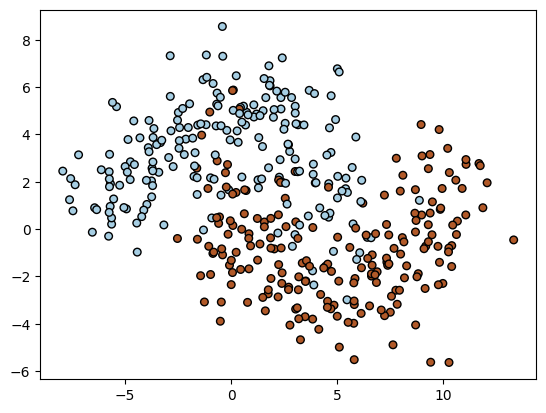

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Load the moon dataset and visualize the points and two classes
X, Y = make_moons(n_samples=400, noise=0.3, random_state=0)
X = 5 * X
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")

**Aufgabe 1.1: Reskalieren der Daten**

Nutzen sie den MinMaxScaler von sklearn um die Daten in ein geeignetes Intervall von (-1,1) zu skalieren. 

Der MinMaxScaler wird mit einem Tuple des gewünschten Intervall initi**Aufgabe 1.1: Reskalieren der Daten**

Nutzen Sie den `MinMaxScaler` aus `sklearn`, um die Daten in das Intervall (-1, 1) zu skalieren.

Der `MinMaxScaler` wird mit einem Tupel für das gewünschte Intervall initialisiert:
```python
MinMaxScaler(feature_range=(a, b))
```

Die Daten können anschließend mit der Methode `fit_transform` skaliert werden:
```python
X = min_max_scaler.fit_transform(X)
````

In [2]:
from sklearn.preprocessing import MinMaxScaler

# TODO Implementierung Aufgabe 1.1

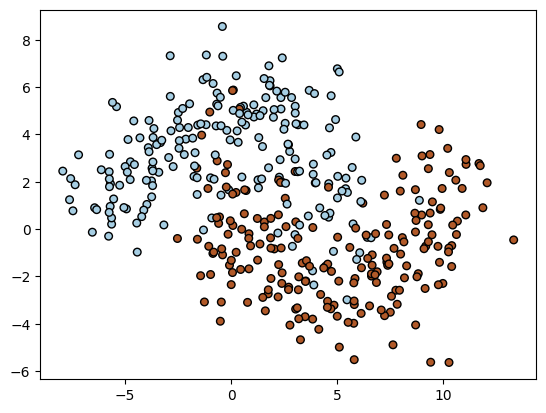

In [3]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")

**Aufgabe 1.2: Train-Test-Split**

Als nächstes sollen die Eingangsdaten (`X`) und die zugehörigen Labels (`Y`) in Trainings- und Testdaten aufgeteilt werden.  
Hierfür können Sie die Funktion `train_test_split` aus `sklearn` verwenden:

```python
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=??, random_state=??)
```

Verwenden Sie für ``test_size`` den Wert 0.2.
Dies entspricht einer Aufteilung von 80 % Trainingsdaten und 20 % Testdaten. Für ``random_state`` können sie eine beliebige Zahl nehmen. 

In [4]:
from sklearn.model_selection import train_test_split

# TODO Implementierung Aufgabe 1.2
X_train = X  # Entfernen
X_test = X  # Entfernen

Hier können Sie die Größer der Traings- und Testdaten sehen:

In [5]:
print("Anzahl der Traingsdaten:", len(X_train))
print("Anzahl der Testdaten:", len(X_test))

Anzahl der Traingsdaten: 400
Anzahl der Testdaten: 400


**Aufgabe 1.3: Definition des parametrisierten Schaltkreises**

Für unser QNN verwenden wir einen vordefinierten Schaltkreis aus sQUlearn.  
In sQUlearn werden diese Schaltkreise als *Encoding Circuits* bezeichnet.

Initialisieren Sie den parametrisierten Schaltkreis ``YZ_CX_EncodingCircuit`` mit  
- `num_qubits = 4`  
- `num_layers = 4`  
- `num_features = 2`

Nachdem der Schaltkreis erzeugt wurde, können Sie ihn mit der Funktion 
```python
encoding_circuit.draw('mpl')
```

visualisieren.

In [6]:
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit

# TODO Implementierung Aufgabe 1.3

**Aufgabe 1.4: Observable**

Als Nächstes benötigen wir eine Observable, die als Ausgabefunktion des QNN dient.  
Auch hier nutzen wir einen vordefinierten Baustein aus sQUlearn.  
Mit der Klasse `SummedPaulis` können Sie eine Observable der Form

$O(\vartheta) = \vartheta_1 I + \vartheta_2 Z_1 + \ldots + \vartheta_{n+1} Z_n$

definieren.

Initialisieren Sie die Observable mit `num_qubits = 4`.  
Geben Sie die erzeugte Observable anschließend mit der `print`-Funktion aus.

In [7]:
from squlearn.observables import SummedPaulis

# TODO Implementierung Aufgabe 1.4

**Aufgabe 1.5: Der Executor**

In *sQUlearn* werden alle Simulationen und Ausführungen zentral über den sogenannten *Executor* gesteuert.  
Im Hintergrund können verschiedene Quanten-SDKs verwendet werden. Nicht nur Qiskit, wie wir es bisher kennengelernt haben.  
Der Executor wird dazu entweder mit einem passenden Backend-Objekt oder mit einem String initialisiert.

In diesem Praktikum nutzen wir nicht Qiskit, sondern einen Simulator, der unsere QNNs deutlich schneller ausführen kann: **Qulacs**.

Um Qulacs zu verwenden, initialisieren Sie den Executor mit dem String ``"qulacs"``.

Später werden wir den Executor alternativ auch mit einem Qiskit-Backend initialisieren, zum Beispiel mit einem simulierten Backend (`FakeTorino()`) oder einem realen Backend der verfügbaren Quantenhardware.

In [8]:
from squlearn import Executor
from qiskit_ibm_runtime.fake_provider import FakeTorino

# TODO Implementierung Aufgabe 1.5

**Aufgabe 1.6: Aufbau des QNNs**

Als Nächstes initialisieren wir das QNN für die Klassifikation mit sQUlearn.  
Neben dem Encoding-Circuit, der Observable und dem Executor benötigt das QNN zusätzlich eine Loss-Funktion (Fehlerfunktion) sowie einen Optimierer.

Für die Loss-Funktion können Sie `SquaredLoss()` verwenden, welche dem quadratischen Fehler entspricht:  $L = \sum_i |f(x_i) - y_i|^2$.

Für die Optimierung nutzen wir **Adam**, einen Optimierer, der auch standardmäßig in klassischen neuronalen Netzen eingesetzt wird.  
Für dieses Beispiel können wir die Standardeinstellungen verwenden und den Optimierer einfach ohne weitere Argumente initialisieren: ``Adam()``.

Das QNN für die Klassifikation wird in sQUlearn mit der Klasse ``QNNClassifier`` erstellt.
Die Initialisierung benötigt folgende Eingaben:

```python
qnn = QNNClassifier(
    encoding_circuit=??,
    operator=??,     # entspricht der Observable
    executor=??,
    loss=??,
    optimizer=??
)
```


In [9]:
from squlearn.qnn import QNNClassifier
from squlearn.optimizers import Adam
from squlearn.qnn.loss import SquaredLoss


# TODO Implementierung Aufgabe 1.6

**Aufgabe 1.7: Training des QNN-Klassifikators**

Im nächsten Schritt starten wir das Training des QNNs.  
Dies erfolgt, analog zum sklearn-Standard, über die Methode `fit`:

```python
qnn.fit(X_train, Y_train)
```

Während des Trainings wird der Fortschritt der Optimierung ausgegeben.
Je nach verwendetem Quanten-SDK, Simulator oder Backend kann das Training unterschiedlich lange dauern.

Auftretende Warnungen können Sie ignorieren!

In [10]:
# TODO Implementierung Aufgabe 1.7

**Aufgabe 1.8: Evaluierung**

Nach dem Training können wir die Genauigkeit unseres Modells auf den Trainings- und Testdaten evaluieren.  
Dazu verwenden wir die `score`-Funktion: ``qnn.score(X, Y)``


Ein Score von `1.0` entspricht einer Genauigkeit von 100 %, d. h. alle Datenpunkte wurden korrekt klassifiziert.
Berechnen und geben Sie den Score sowohl für die Trainingsdaten als auch für die Testdaten aus.

In [11]:
# TODO Implementierung Aufgabe 1.8

**Aufgabe 1.9: Analyse des Modells**

Um einen besseren Eindruck von der Leistungsfähigkeit des Modells zu erhalten, visualisieren wir die Entscheidungsgrenze des QNN-Klassifikators — also die Grenze zwischen den beiden Klassen.  

Für die Visualisierung können Sie die folgende Hilfsfunktion verwenden, die den Plot automatisch erzeugt.


In [12]:
def plot_decision_boundary(qnn, X_train, Y_train, X_test, Y_test):
    """Plot the decision boundary of a QNN classifier.

    Args:
        qnn: Trained QNN classifier.
        X_train: Training feature data.
        Y_train: Training labels.
        X_test: Test feature data.
        Y_test: Test labels.

    Returns:
        Matplotlib plot object with decision boundary and data points.
    """

    xx, yy = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))
    Z = qnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c=Y_train,
        edgecolor="k",
        marker="X",
        label="Training Data",
    )
    plt.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=Y_test,
        edgecolor="k",
        marker="o",
        label="Test Data",
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("QRC Classification Inference")
    plt.legend()
    return plt

Erzeugen Sie nun einen Plot der Entscheidungsgrenze Ihres QNNs mithilfe der bereitgestellten Hilfsfunktion.

In [13]:
# TODO Implementierung Aufgabe 1.9

**Aufgabe 1.10: Einfluss der Layer-Anzahl**

Zum Schluss untersuchen wir den Effekt der Anzahl an Layern (also der Wiederholungen der Gatter im Encoding-Circuit) auf die Modellperformance.

Kopieren Sie den Code aus den vorherigen Aufgaben und passen Sie anschließend die Anzahl der Layer im Encoding-Circuit an.  
Testen Sie die folgenden Werte für `num_layers`: 1,2,3,4

Beobachten und beschreiben Sie, wie sich die Anzahl der Layer auf das Modellverhalten auswirkt.

In [14]:
# TODO Implementierung Aufgabe 1.10

### Aufgabe 2: Regression mit einem Quanten-Neuronalen Netzwerk

In dieser Aufgabe betrachten wir eine univariate (1D) Regression.  
Wir verwenden ein QNN, um eine Funktion $f : \mathbb{R} \rightarrow \mathbb{R}$ zu approximieren.  

Die Ziel­funktion sowie die dazugehörigen Trainingsdaten sind in den folgenden Notebook-Zellen gegeben.

In [15]:
# Funktion zum Approximieren
def f(x):
    return np.sin(10.0 * x) * np.cos(np.exp(2 * x))

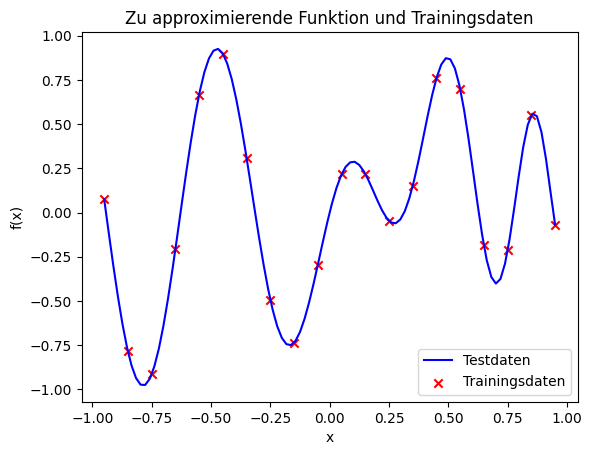

In [16]:
# Erzeugen von Trainings- und Testdaten
X_test = np.linspace(-0.95, 0.95, 100).reshape(-1, 1)
X_train = np.linspace(-0.95, 0.95, 20).reshape(-1, 1)
Y_train = f(X_train)
Y_test = f(X_test)
plt.title("Zu approximierende Funktion und Trainingsdaten")
plt.plot(X_test, Y_test, label="Testdaten", color="blue")
plt.scatter(X_train, Y_train, label="Trainingsdaten", color="red", marker="x")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

**Aufgabe 2.1: Parametrisierter Quantenschaltkreis**

Wir beginnen erneut mit dem parametrisierten Quantenschaltkreis für unser QNN.  
Auch hier verwenden wir einen vordefinierten Schaltkreis aus sQUlearn: `ChebyshevPQC`.

Initialisieren Sie den Schaltkreis mit  
- 3 Qubits (``num_qubits``),  
- 2 Layern (``num_layers``)   
- Feature-Dimension (`num_features`) von 1.

Visualisieren Sie den Schaltkreis anschließend mit der Funktion `encoding_circiut.draw('mpl')`.

In [17]:
from squlearn.encoding_circuit import ChebyshevPQC

# TODO Implementierung Aufgabe 2.1

**Aufgabe 2.2: Definition des QNN**

Für das Regressionsbeispiel verwenden wir diesmal die Klasse `QNNRegressor` aus sQUlearn.  
Die Initialisierung erfolgt analog zum `QNNClassifier` aus Aufgabe 1.

Als Observable nutzen wir erneut `SummedPaulis`, diesmal mit 3 Qubits.

Für eine bessere Trainingsleistung passen wir außerdem die Optimierung an und verwenden:

```python
Adam(options={'lr': 0.1, 'maxiter': 300})
```

Initialisieren Sie nun den ``QNNRegressor`` mit dem parametrisierten Schaltkreis, der Observable, dem Executor sowie der angegebenen Loss-Funktion und dem Optimierer.

In [18]:
from squlearn.qnn import QNNRegressor

# TODO Implementierung Aufgabe 2.2

**Aufgabe 2.3: Training des QNN**

Wie in Aufgabe 1 wird das QNN mit der `fit`-Funktion trainiert: ``qnn.fit(X_train, Y_train)``

In [19]:
# TODO Implementierung Aufgabe 2.3

**Aufgabe 2.4: Inferenz auf den Testdaten**

Als Nächstes untersuchen wir, wie gut das QNN die zugrunde liegende Funktion approximieren kann.  
Berechnen Sie dazu die Vorhersagen des Modells mit der `predict`-Funktion:
```python
qnn.predict(X_test)
```

Fügen Sie das Ergebnis dem Plot hinzu.

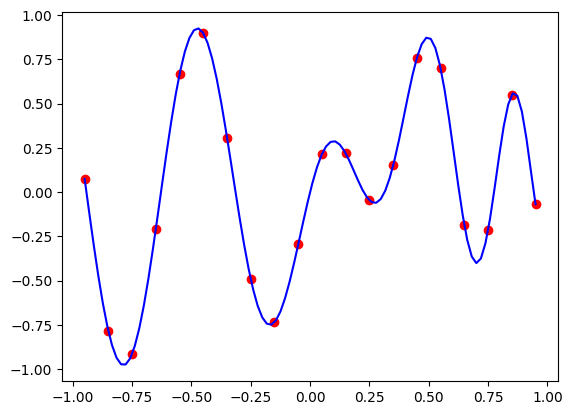

In [20]:
plt.plot(X_test, Y_test, label="True Function", color="blue")
plt.scatter(X_train, Y_train, label="Training Data", color="red")
# TODO Implementierung Aufgabe 2.4

**Aufgabe 2.5: Einfluss der Layer-Anzahl**

Untersuchen Sie nun die Vorhersagequalität des QNNs für unterschiedliche Anzahlen an Layern.  
Reduzieren Sie dazu zunächst die Anzahl der Qubits sowohl im Schaltkreis als auch in der Observable auf 2  
und testen Sie anschließend folgende Einstellungen für `num_layers`:

- `num_layers = 1`
- `num_layers = 2`
- `num_layers = 3`
- `num_layers = 4`

Beobachten und beschreiben Sie, wie sich die Anzahl der Layer auf die Regressionsleistung auswirkt.


In [21]:
# TODO Implementierung Aufgabe 2.5

**Aufgabe 2.6: Einfluss der Qubit-Anzahl**

Untersuchen Sie nun die Vorhersagequalität des QNNs für unterschiedliche Anzahlen an Qubits.  
Setzen Sie dazu die Anzahl der Layer fest auf `num_layers = 2` und testen Sie folgende Qubit-Zahlen:

- `num_qubits = 2`
- `num_qubits = 4`
- `num_qubits = 6`

Beobachten und beschreiben Sie, wie sich die Anzahl der Qubits auf die Regressionsleistung und das Modellverhalten auswirkt.

In [22]:
# TODO Implementierung Aufgabe 2.6

**Aufgabe 2.7: Ausführung auf einem simulierten Hardware-Backend**

Nun wollen wir das optimierte QNN auf einem simulierten Hardware-Backend ausführen.

Dazu müssen wir das QNN vollständig neu initialisieren und den Executor mit einem passenden Backend versehen.  
Für diese Aufgabe verwenden wir ein simuliertes Qiskit-Backend:

```python
Executor(FakeTorino())
```

Zunächst speichern wir die optimierten Parameter aus dem zuvor trainierten Modell ab (z. B. für ``num_qubits = 3`` und ``num_layers = 3``):
```python
param = qnn.param      # Optimierte Parameter des Schaltkreises
param_op = qnn.param_op  # Optimierte Parameter der Observable
```

Anschließend initialisieren wir ein neues QNN mit dem simulierten Backend und den gespeicherten Parametern:
```python
qnn_noisy = QNNRegressor(
    encoding_circuit=encoding_circuit,
    operator=observable,
    executor=Executor(FakeTorino()),
    loss=SquaredLoss(),
    optimizer=Adam(options={'lr': 0.1, 'maxiter': 300}),
    param_ini=qnn.param,
    param_op_ini=qnn.param_op,
    pretrained=True # wir starten mit einem trainierten Model
)
```

Erzeugen Sie nun den Plot wie in Aufgabe 2.4, diesmal jedoch mit dem simulierten Hardware-Backend.
Hierfür genügt es, die Vorhersagen über ``qnn_noisy.predict(X_test)`` zu berechnen. Das Training mittels fit würde auf diesem Backend mehrere Stunden dauern und braucht daher nicht ausgeführt werden!

Was beobachten Sie im Output?

In [23]:
# TODO Implementierung Aufgabe 2.1

**Aufgabe 2.8: Training des Modells auf der simulierten Hardware**

Das Training auf einem simulierten Hardware-Backend ist deutlich aufwändiger, da die Simulation von Rausch- und Hardwareeffekten sehr rechenintensiv ist.  
In der nächsten Zelle finden Sie daher bereits die Parameter eines Modells, das auf diesem Backend optimiert wurde (die vollständige Optimierung dauerte über 3 Stunden).

Gehen Sie wie in Aufgabe 2.7 vor, verwenden Sie jedoch die bereitgestellten Parameter anstelle der zuvor ermittelten.

Was beobachten Sie, wenn das Training vollständig auf dem simulierten Hardware-Backend durchgeführt wurde?

In [24]:
param = np.array(
    [
        1.72900469,
        4.97609589,
        0.4143024,
        -2.98540414,
        1.32905107,
        4.45668286,
        0.50964186,
        1.59528737,
        7.36515257,
        2.71861796,
        1.6022716,
        4.54418353,
        -3.89268032,
        -0.18647767,
        -10.28556231,
        -1.27242119,
        1.26923248,
        6.12471644,
        9.55561971,
        8.0686719,
        5.21766519,
        2.13012914,
        -1.53696626,
        -0.98270393,
    ]
)

param_op = np.array([0.04130383, -0.28962778, -0.41235333, -1.02624356])

In [25]:
# TODO Implementierung Aufgabe 2.8